#Итоговый проект

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from os import listdir
import codecs
import pickle                                                                   
from bs4 import BeautifulSoup as BS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from boilerpipe.extract import Extractor
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.sparse import hstack
from scipy.sparse import vstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.svm import OneClassSVM
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
submit = False

In [3]:
train_data = pd.read_csv('train_groups.csv',dtype=np.int16)

In [ ]:
#это парсинг теста
if submit:
    test_data= pd.read_csv('test_groups.csv',dtype=np.int16)

    parser_type = 'NumWordsRulesExtractor'
    def save_obj(obj, name ):                                                       
        with open(name + '.pkl', 'wb') as f:                                        
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)                            

    def load_obj(name ):                                                            
        with open(name + '.pkl', 'rb') as f:                                        
            return pickle.load(f)                                                   

    path = 'content/'                                                               
    texts = {}                                                                      
    print('Start: ' + parser_type)                                                  
    test_data = pd.read_csv('test_groups.csv',dtype=np.int16)                      
    #for filename in ['6770.dat']:                                                  
    for filename in tqdm(listdir(path)):                                            
        doc_id = int(filename.strip('.dat'))                                        
        if doc_id not in test_data.doc_id.values:                                  
            continue                                                                
        try:                                                                        
            with codecs.open(path + filename, 'r', encoding='utf-8', errors='ignore') as f:
                url = f.readline().strip()                                          
                html = f.read()                                                     
                extractor = Extractor(extractor=parser_type, html=html)             
                s = extractor.getText()                                             
                s=s.replace('\n'," ")                                               
                s=s.replace('\t'," ")                                               
                s=s.replace('\r'," ")                                               
                texts[doc_id] = s                                                   
        except UnicodeDecodeError: 
            print('error {}'.format(filename))                                      
            with codecs.open(path + filename, 'r', 'utf-8') as f:                   
                url = f.readline().strip()                                          
                html = f.read()                                                     
            bs = BS(html, 'html.parser')#ищем след страницу                         
            for s in bs.select('script'):                                           
                s.extract()                                                         
            s = bs.get_text()                                                       
            s=s.replace('\n',"")                                                    
            s=s.replace('\t',"")                                                    
            s=s.replace('\r',"")                                                    
            texts[doc_id] = s                                                       
    test_data['text'] = test_data.apply(lambda row: texts[row.doc_id], axis = 1)  


In [4]:
def save_obj(obj, name ):                                                       
    with open(name + '.pkl', 'wb') as f:                                        
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)                            
                                                                                
def load_obj(name ):                                                            
    with open(name + '.pkl', 'rb') as f:                                        
        return pickle.load(f)       

In [5]:
name = 'NumWordsRulesExtractor'
name = 'train_data'+name
train_data = load_obj(name)#Загружаем готовый распарсенный текст уже

In [6]:
doc_to_title = {}
with open('docs_titles.tsv', encoding = 'UTF-8') as f:
    for num_line, line in enumerate(f):
        if num_line == 0:
            continue
        data = line.strip().split('\t', 1)
        doc_id = int(data[0])
        if len(data) == 1:
            title = ''
        else:
            title = data[1]
        doc_to_title[doc_id] = title
doc_titles = []
for id in train_data.doc_id.values:
    doc_titles.append(doc_to_title[id])
train_data['title'] = doc_titles
if submit:
    test_doc_titles = []
    for id in test_data.doc_id.values:
        test_doc_titles.append(doc_to_title[id])
    test_data['title'] = test_doc_titles
print(len(doc_titles))


11690


In [7]:
def get_splits(data, n=3, random_state=None):
    groups = train_data.group_id.unique()
    kf = KFold(n_splits=n, shuffle=True, random_state=random_state)
    for i,j in kf.split(groups):
        train, test = data.group_id.isin(groups[i].reshape(-1)), data.group_id.isin(groups[j].reshape(-1))
        yield (train[train].index.values, test[test].index.values)

In [57]:
#vectorizer = CountVectorizer(ngram_range = (1,3))#max_features = 70)
vectorizer = CountVectorizer()

In [9]:
all_groups = np.array(list(range(1,310))).reshape(-1,1)
i = OneHotEncoder()
i.fit(all_groups)
groups_one_hot_train = i.transform(train_data.group_id.values.reshape(-1,1))
if submit:
    groups_one_hot_test   = i.transform(test_data.group_id.values.reshape(-1,1))

In [58]:
def get_features(data):
    scaler = StandardScaler(with_mean=False)
    number = 1
    for group in tqdm(data.group_id.unique()):
        number +=1
        elements_in_same_group = data.group_id == group

        vectorizer.fit(data.title[elements_in_same_group] + data.text[elements_in_same_group])
        texts_vectorized_titles = vectorizer.transform(data.title[elements_in_same_group])
        texts_vectorized_titles = scaler.fit_transform(texts_vectorized_titles)

        texts_vectorized_texts = vectorizer.transform(data.text[elements_in_same_group])
        texts_vectorized_texts = scaler.fit_transform(texts_vectorized_texts)

        dist_matr = pairwise_distances(texts_vectorized_titles, texts_vectorized_titles, metric = 'cosine')
        dist_matr2 = pairwise_distances(texts_vectorized_texts, texts_vectorized_texts, metric = 'cosine')
        dist_matr3 = pairwise_distances(texts_vectorized_texts, texts_vectorized_titles, metric = 'cosine')

        #clustering = DBSCAN(eps = 1.3, min_samples=5).fit(dist_matr)
        #clf = IsolationForest(random_state=0).fit_predict(dist_matr)
        #pca = TruncatedSVD(n_components=5)
        #texts_vectorized_titles = pca.fit_transform(texts_vectorized_titles)
        
        X = TSNE(n_components=2).fit_transform(texts_vectorized_titles)
        print(X.shape)
        x_axis = X[:,0]
        y_axis= X[:,1]
        plt.scatter(x_axis, y_axis, c=data.target[elements_in_same_group])
        plt.xlabel("x")
        plt.ylabel("y")
        plt.show()

        pca = TruncatedSVD(n_components=5)
        texts_vectorized_titles = pca.fit_transform(texts_vectorized_titles)
        clf = LocalOutlierFactor(n_neighbors=20)
    
        labels = clf.fit_predict(texts_vectorized_titles)
        #print(labels)
        #print(target[elements_in_same_group])
        dist_matr_sorted = np.sort(dist_matr,axis=1)[:,0:21]
        dist_matr_sorted2 = np.sort(dist_matr2,axis=1)[:,0:21]
        dist_matr_sorted3 = np.sort(dist_matr3,axis=1)[:,0:21]


        mean_dist = dist_matr.mean(axis = 1)
        dist_matr_sorted = np.hstack((dist_matr_sorted, mean_dist.reshape(-1,1)))
        dist_matr_sorted = np.hstack((dist_matr_sorted, dist_matr_sorted2))
        dist_matr_sorted = np.hstack((dist_matr_sorted, dist_matr_sorted3))
        dist_matr_sorted = np.hstack((dist_matr_sorted, labels.reshape(-1,1)))
    #   dist_matr_sorted = hstack((dist_matr_sorted, texts_vectorized))

        if number == 2 :
            features_by_dist =  dist_matr_sorted
        else:
            features_by_dist = vstack((features_by_dist, dist_matr_sorted))
    return features_by_dist.tocsr()

(102, 22600)
(102, 2)


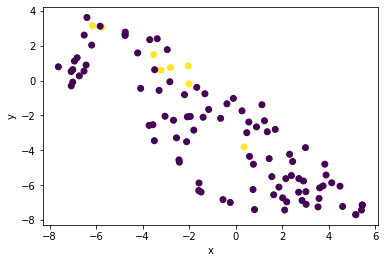

(94, 89146)
(94, 2)


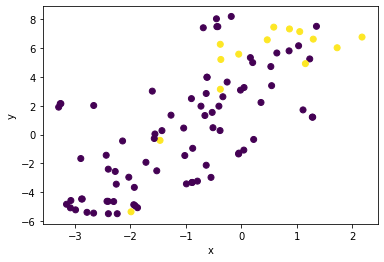

(98, 172800)
(98, 2)


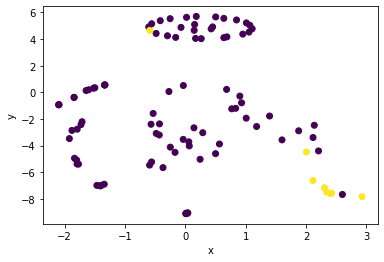

(88, 79248)
(88, 2)


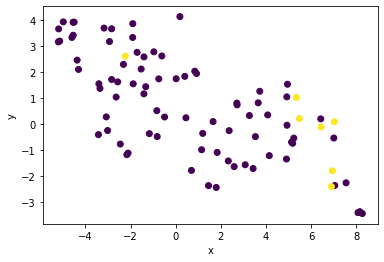

(108, 66899)


KeyboardInterrupt: 

In [59]:
if submit:
    features_by_dist = get_features(test_data)
    features_by_dist = hstack([features_by_dist, groups_one_hot_test])
    features_by_dist = features_by_dist.tocsr()
else:
    target = train_data.target.values
    features_by_dist = get_features(train_data)
    features_by_dist = hstack([features_by_dist, groups_one_hot_train])
    features_by_dist = features_by_dist.tocsr()

In [31]:
#VALIDATION
max_score = 0
scores = []
for i in tqdm(range(5)):
    for train, test in get_splits(train_data,n=3,random_state=i):
        model = RandomForestClassifier(n_jobs=6,n_estimators=200)
        model.fit(features_by_dist[train], target[train])
        pred = (model.predict(features_by_dist[test]))               
        score = f1_score(pred,target[test])
        scores.append(score)
        print(score, end=' ')
    print()

print('\nAvg score:' ,sum(scores)/len(scores))

0.72648835202761 0.7259190321079573 0.7021387584767868 
0.7000486144871172 0.7270363951473136 0.6895181321410829 
0.7589869281045751 0.7252276379217996 0.6399609184171958 
0.754225012071463 0.6958386958386958 0.696923852748361 
0.6699595868881904 0.7190243902439023 0.7543284978942443 


Avg score: 0.712374986967753


In [19]:
max(res_scores) #20 estim

(0.7121791250258608, 0.201, 9)

In [21]:
#VALIDATION
max_score = 0
res_scores = []
for learning_rate in [0.002]:
    for max_depth in [9]:
        scores = []
        for i in range(5):
            for train, test in get_splits(train_data,n=3,random_state=i):
                #model = RandomForestClassifier(n_jobs=6,n_estimators=200)
                #model = xgboost.XGBClassifier(n_estimators=200, n_jobs=-1)
                model = GradientBoostingClassifier(n_estimators=2000, learning_rate=learning_rate, max_depth=max_depth)
                model.fit(features_by_dist[train], target[train])
                pred = (model.predict(features_by_dist[test]))               
                score = f1_score(pred,target[test])
                scores.append(score)
            #print(score, end=' ')
        #print()

        print('\nAvg score:' ,sum(scores)/len(scores))
        res_scores.append((sum(scores)/len(scores), learning_rate, max_depth))


Avg score: 0.7150697373455935


In [ ]:
#SAVE model
from sklearn.ensemble import RandomForestClassifier 
model = RandomForestClassifier(n_jobs=6,n_estimators=200)
model.fit(features_by_dist, target)
save_obj(model, 'model')

In [ ]:
#SUBMIT
from sklearn.ensemble import RandomForestClassifier 
print(type(features_by_dist))
model = load_obj('model') 
pred = (model.predict(features_by_dist)               
pred.shape

In [ ]:
test_data['target'] = pred
test_data.to_csv('sub',index=False,columns=['pair_id','target'])